In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns


import pickle

In [2]:

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Reading, extracting and slicing data (Psychopy and Shimmer)

In [3]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## Normalize  data

In [4]:
def normalize_data_min_max (std_df, signal_col):
    # std_df: data frame
    # signal_col: col of interest
    
    signal = std_df[signal_col].to_list()
    
    
    signal_float =[float(val) for val in signal]
    
    signal_float_np = np.array(signal_float)
    
    
    min_val = np.min(signal_float_np)
    max_val = np.max(signal_float_np)
    
    range_val = max_val-min_val
    
    
    min_sub = signal_float_np - min_val
    
    scaled_data = min_sub/range_val
    
    
    std_df["min_max_norm"] = scaled_data
    
    return std_df

In [5]:
def min_max_norm(all_rr_one_list, all_rr_sublist):
    
    mean_norm_list =[]
    std_norm_list = []
    
    all_rr_one_list = np.array(all_rr_one_list)
    max_val = np.max(all_rr_one_list)
    min_val =np.min(all_rr_one_list)
    
    for sel_list in all_rr_sublist:
        
        sel_list_np = np.array(sel_list)
        
        range_list = max_val-min_val
        
        sel_lis_np_sub = sel_list_np - min_val
        
        sel_lis_norm= sel_lis_np_sub/range_list
        
        mean_norm = np.mean(sel_lis_norm)
        mean_norm_list.append(mean_norm)
        
        std_norm  = np.std(sel_lis_norm)   
        std_norm_list.append(std_norm)
        #print(mean_norm)
        #print(std_norm)
                
        
    return mean_norm_list, std_norm_list

## Plotting data

In [6]:
def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig

## HRV: Time Domain Analysis

In [7]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
 



def filter_rr(rr, throshold_high=0.5, threshold_low=0.5):
    
    #outlier_high = np.mean(rr) + throshold_high * np.std(rr)
    outlier_high =1500
    #print(outlier_high)
    
    rr_clean_high = [rr_val for rr_val in rr if rr_val <  outlier_high]
    
    rr_clean_high = np.array(rr_clean_high)
    
    #outlier_low = np.mean(rr_clean_high) - threshold_low*np.std(rr_clean_high)
    outlier_low = 400
    #print(outlier_low)
    
    rr_clean_high_low = [rr_val for rr_val in rr_clean_high if rr_val >  outlier_low]
    
    rr_clean_high_low= np.array(rr_clean_high_low)
    
    return rr_clean_high_low



def remove_outliers_rri(r_peaks, sampling_freq = 256):
    
    # RR-intervals are the differences between successive peaks
    r_peaks_sec = r_peaks*1/sampling_freq
    r_peaks_msec = r_peaks_sec*1000

    r_peaks_diff=np.diff(r_peaks_msec)
    
    rr_corrected = r_peaks_diff.copy()

    rr_corrected[np.abs(zscore(r_peaks_diff)) > 2] = np.median(r_peaks_diff)
    
    return rr_corrected
    


        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## HRV: Frequency Domain

In [8]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Fetching info and calculate mean and standard deviation 

In [9]:
def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []
    
    all_rr_one_list = []
    all_rr_sublist = []
     

    ##---outer loop to handle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min_print

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            
            print(event_plot)
            
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)
            
            #print(sensor_df_ii)
            
            ecg_df_ii=sensor_df_ii.reset_index(drop=True)
            
            
            #cond_slice_main = (ecg_df_ii[timestamp_sensor_col_name] >= timestamp_start_slice) & (ecg_df_ii[timestamp_sensor_col_name] < timestamp_end_slice)
            
            #ecg_slice = ecg_df_ii.heartrate
            ecg_slice = ecg_df_ii[data_col_name].values
            out = ecg.ecg(signal=ecg_slice, sampling_rate=256, show=False,interactive=False)
            
            r_peaks = out["rpeaks"]
            r_peaks_diff = remove_outliers_rri(r_peaks, sampling_freq = 256)
            
            r_peaks_diff=filter_rr(r_peaks_diff)
            
            #r_peaks_sec = r_peaks*1/256
            #r_peaks_msec = r_peaks_sec*1000

            #r_peaks_diff=np.diff(r_peaks_msec)
            
            
            
            
            print(timedomain(r_peaks_diff))
            

            
            #peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
            #grouped_peaks = group_peaks(peaks)
            #grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
            #rr = np.diff(grouped_peak_msec)
            #print(timedomain(rr))
            
            
            #cleaned_rr = filter_rr(r_peaks_diff)
            cleaned_rr=r_peaks_diff
            mean_rr = np.mean(cleaned_rr) 
            std_rr = np.std(cleaned_rr)
            
            mean_cumm_list.append(mean_rr)
            std_cumm_list.append(std_rr)
            
            all_rr_one_list.extend(cleaned_rr)
            all_rr_sublist.append(cleaned_rr)
            
            
            #event_interets_plot
            
            #print(np.mean(cleaned_rr))
            #print(np.std(cleaned_rr))
            


            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot, all_rr_one_list, all_rr_sublist

## Paths and files

In [15]:
data_dir_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/new_data"
#data_dir_path = "D:/Datasets/data_sony_digiRelax/new_participants"
#data_dir_path = "D:/Datasets/data_sony_digiRelax/study"
sub_dirs=next(os.walk(data_dir_path))[1]
sub_dirs=sorted(sub_dirs)

In [16]:
sub_dirs

['VP083_310124', 'VP084_310124']

In [17]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5]]

In [18]:
#dest_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub/hrv/ibi_filtered_pkl_84_subjects"
#dest_path = "D:/Datasets/analysis_digirelax"
dest_path = "D:/Datasets/data_sony_digiRelax/anal_results"
designated_folder = "hrv_analysis"
comp_dest_path = os.path.join(dest_path, designated_folder)

isexist = os.path.exists(comp_dest_path)

if not isexist:
    os.makedirs(comp_dest_path)
    print("The new directory is created")

The new directory is created


/home/muhammad/Desktop/Datasets/data_sony_digiRelax/new_data/VP083_310124/Psychopy_data/VP083_310124_DigiRelax_Experiment_2024-01-31_09h50.52.785.csv
VP083_310124_DigiRelax_Experiment_2024-01-31_09h50.52.785
baseline_instruction_ts 3 min
{'Mean RR (ms)': 710.2838645418327, 'STD RR/SDNN (ms)': 54.99177904406125, 'Mean HR (beats/min)': 84.97865092366706, 'STD HR (beats/min)': 6.560452949383619, 'Min HR (beats/min)': 71.11111111111111, 'Max HR (beats/min)': 102.4, 'RMSSD (ms)': 41.75487083300881, 'NNxx': 46, 'pNNxx (%)': 18.326693227091635}
tsst_prep_ts 5 min
{'Mean RR (ms)': 447.70262557077626, 'STD RR/SDNN (ms)': 28.772045227873047, 'Mean HR (beats/min)': 134.55118759749934, 'STD HR (beats/min)': 8.327037575537048, 'Min HR (beats/min)': 113.77777777777777, 'Max HR (beats/min)': 149.126213592233, 'RMSSD (ms)': 14.97197331863205, 'NNxx': 19, 'pNNxx (%)': 2.8919330289193304}
tsst_pres_ts 5 min
{'Mean RR (ms)': 421.3310917721519, 'STD RR/SDNN (ms)': 17.61390058010576, 'Mean HR (beats/min)':

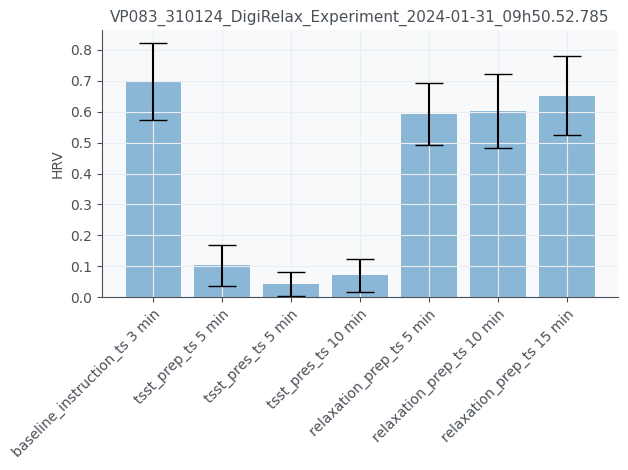

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/new_data/VP084_310124/Psychopy_data/VP084_310124_DigiRelax_Experiment_2024-01-31_13h14.59.762.csv
VP084_310124_DigiRelax_Experiment_2024-01-31_13h14.59.762
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1095.8828604294479, 'STD RR/SDNN (ms)': 77.74688316286353, 'Mean HR (beats/min)': 55.0306574647462, 'STD HR (beats/min)': 3.961461196174743, 'Min HR (beats/min)': 48.0, 'Max HR (beats/min)': 64.53781512605042, 'RMSSD (ms)': 71.01827177207214, 'NNxx': 88, 'pNNxx (%)': 53.987730061349694}
tsst_prep_ts 5 min
{'Mean RR (ms)': 875.6954747774481, 'STD RR/SDNN (ms)': 80.48450284886364, 'Mean HR (beats/min)': 69.09551283293835, 'STD HR (beats/min)': 6.343117632151714, 'Min HR (beats/min)': 55.65217391304348, 'Max HR (beats/min)': 86.77966101694915, 'RMSSD (ms)': 64.17916161513237, 'NNxx': 122, 'pNNxx (%)': 36.201780415430264}
tsst_pres_ts 5 min
{'Mean RR (ms)': 715.3639527845037, 'STD RR/SDNN (ms)': 60.323255558188414, 'Mean HR (beats/min)': 8

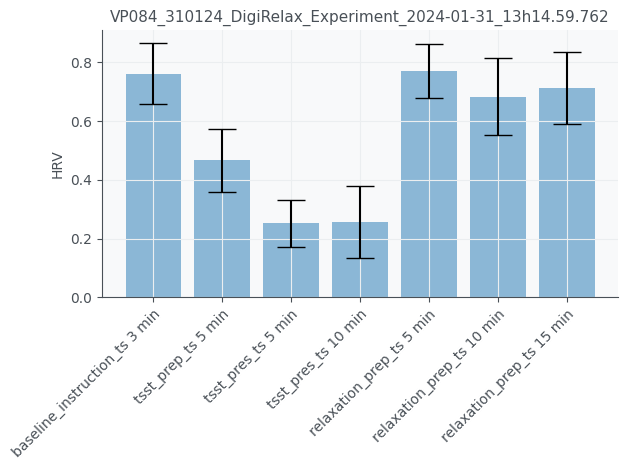

In [14]:
for sub_dir in sub_dirs:
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy_data")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    print(psychopy_file_path)
    
    fol_path, file_name_ii=os.path.split(psychopy_file_path)
    
    sub_id=file_name_ii[:-4]
    
    
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer_data")
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    #print(shimmer_files_name)
    
    for sh_file in shimmer_files_name:
        
        if '_6B1E_' in sh_file:
            hr_shimmer_path = sh_file
            
    fol_path, file_name=os.path.split(psychopy_file_path)
    sub_id=file_name[:-4]
    print(sub_id)
    
    ## heart rate
    timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
    ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
    
    hr_df=read_shimmer_sensor(hr_shimmer_path)
    hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
    
    
    selected_ecg_df = hr_df[[timestamp_hr_col, ecg_col_name]]
    selected_ecg_df = selected_ecg_df.copy()
    selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
    selected_ecg_df=col_from_str_float(selected_ecg_df, "heartrate")
    
    #selected_ecg_df =  normalize_data_min_max (selected_ecg_df, "heartrate")
    
    
    
    
    
    mean_hrv_list,std_hrv_list, event_interets_plot, all_rr_one_list, all_rr_sublist =  get_mean_std_event_list(psychopy_df, selected_ecg_df, event_interest_list_new, offset_min_list_new, timestamp_hr_col, "heartrate")
    
    norm_mean_hrv, norm_std_hrv = min_max_norm(all_rr_one_list, all_rr_sublist)
    
    ####-----Plot HRV ----------------------------------
    title_figure = "HRV"
    y_label_fig = "HRV"
    fig_hrv=plot_mean_std(norm_mean_hrv, norm_std_hrv, event_interets_plot, sub_id, y_label_fig)
    
    ##### save figure
    name_hrv = "hrv_" + sub_id + ".png" 
    dest_path_fig_hr = os.path.join(dest_path, name_hrv)
    fig_hrv.savefig(dest_path_fig_hr)
    
    #####---------------------Uncomment below for csv --------------------------------------
    #export_dict= {"subject_id":sub_id , 'event_interst': event_interets_plot, "mean_hrv":mean_hrv_list , "std_hrv": std_hrv_list , "norm_mean_hrv":norm_mean_hrv,  "norm_std_hrv": norm_std_hrv}
    #df_export = pd.DataFrame.from_dict(export_dict)
    
    #dest_path_csv = os.path.join(comp_dest_path,file_name_ii)
    ##df_export.to_csv(dest_path_csv)
    ####-------------till here-----------------------------------
    
    
    
    #####################################################################
   ##### uncomment the code below for differrent analysis for raw IBI in msecs 
   #################################################################### 
    

    
    hrv_data_dict = {}
    
    
    hrv_data_dict["subject_id"] = sub_id
    
    hrv_data_dict["event_interst"] = event_interets_plot
    
    hrv_data_dict["all_rr_one_list"] = all_rr_one_list
    
    hrv_data_dict["all_rr_sublists"] = all_rr_sublist
    

    

    pkl_file_hrv = sub_id + ".pkl"
    
    dest_path_csv_hrv = os.path.join(dest_path, pkl_file_hrv)
    with open(dest_path_csv_hrv, "wb") as f:
        pickle.dump(hrv_data_dict, f)
        f.close()
        
    ########################################################
    ####### till here ######################################
    ########################################################
    
        
    
    


{'subject_id': 'VP084_310124_DigiRelax_Experiment_2024-01-31_13h14.59.762',
 'event_interst': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'all_rr_one_list': [1121.09375,
  1089.84375,
  1179.6875,
  1093.75,
  1210.9375,
  1246.09375,
  1183.59375,
  1062.5,
  1167.96875,
  1136.71875,
  1125.0,
  1250.0,
  1148.4375,
  1214.84375,
  1195.3125,
  1066.40625,
  1183.59375,
  1144.53125,
  1082.03125,
  1214.84375,
  1230.46875,
  1167.96875,
  1226.5625,
  1160.15625,
  1054.6875,
  1171.875,
  1191.40625,
  1082.03125,
  1152.34375,
  1175.78125,
  1097.65625,
  1199.21875,
  1242.1875,
  1156.25,
  1175.78125,
  1195.3125,
  1156.25,
  1199.21875,
  1207.03125,
  1160.15625,
  1160.15625,
  1167.96875,
  1156.25,
  1105.46875,
  1156.25,
  1210.9375,
  1117.1875,
  1171.875,
  1175.78125,
  1167.96875,
  1093.75,
  1171.875,
  117

In [15]:
len(all_rr_one_list)

2236

In [18]:
len(all_rr_sublist)

7